필수 모듈 및 패키지 import

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'Colab Notebooks/Generative_Deep_Learning/utils'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
import utils
from utils import display

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics
)

from scipy.stats import norm

# 파라미터 설정

In [4]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

훈련 세트와 테스트 세트 불러오기

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


데이터 전처리

In [6]:
# 데이터 전처리
def preprocess(imgs):
    """
    이미지 정규화 및 크기 변경
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

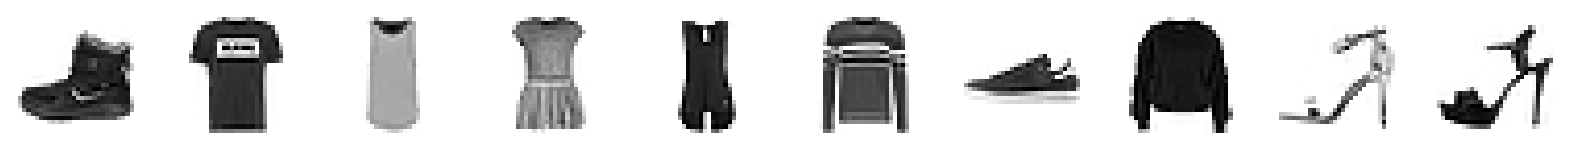

In [7]:
display(x_train)

# 변이형 오토인코더

In [8]:
import tensorflow as tf
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(z_log_var * 0.5) * epsilon

In [9]:
# 인코더를 다시 재정의한다
encoder_input = layers.Input(
    shape = (32,32,1), name = "encoder_input")

x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu",
                  padding = "same")(encoder_input)

x = layers.Conv2D(64, (3,3), strides = 2, activation = "relu",
                  padding = "same")(x)

x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu",
                  padding = "same")(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name = "z_mean")(x)
z_log_var = layers.Dense(2, name = "z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name = "encoder")

In [10]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 디코더
# 합성곱 층 대신에 전치 합성곱 층 transposed convolutional layer를 사용
decoder_input = layers.Input(
    shape = (2,), name = "decoder_input"
)

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3,3), strides = 2, activation = "relu", padding = "same"
)(x)
x = layers.Conv2DTranspose(
    64, (3,3), strides = 2, activation = "relu", padding = "same"
)(x)
x = layers.Conv2DTranspose(
    32, (3,3), strides = 2, activation = "relu", padding = "same"
)(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides = 1,
    activation = "sigmoid",
    padding = "same",
    name = "decoder_output"
)(x)

decoder = keras.Model(decoder_input, decoder_output)

In [12]:
# 디코더는 재정의할 필요가 없다
# 다만 변이형 오토인코더의 손실함수는 재정의해야한다.

from tensorflow.keras import models,metrics, losses


class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name = "total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(
        name = "reconstruction_loss"
    )
    self.kl_loss_tracker = metrics.Mean(name = "kl_loss")


  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def call(self, inputs):
    z_mean, z_log_var, z = encoder(inputs)
    reconstruction = decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, reconstruction = self(data)
      reconstruction_loss = tf.reduce_mean(
          500
          * losses.binary_crossentropy(
              data, reconstruction, axis = (1,2,3)
          )
      )
      kl_loss = tf.reduce_mean(
          tf.reduce_sum(
              -0.5
              * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
              axis = 1,
          )
      )
      total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      return {
          m.name : m.result() for m in self.metrics
      }

In [13]:
# 이제 훈련을 해보자
vae = VAE(encoder, decoder)
vae.compile(optimizer = 'adam')
vae.fit(
    x_train,
    epochs = 5,
    batch_size = 100
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 261s 429ms/step - kl_loss: 3.8496 - reconstruction_loss: 178.9538 - total_loss: 182.8034
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 287s 471ms/step - kl_loss: 4.9743 - reconstruction_loss: 129.7810 - total_loss: 134.7552
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 291s 420ms/step - kl_loss: 5.0481 - reconstruction_loss: 128.4811 - total_loss: 133.5292
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 255s 408ms/step - kl_loss: 5.1228 - reconstruction_loss: 127.4617 - total_loss: 132.5845
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 303s 504ms/step - kl_loss: 5.1748 - reconstruction_loss: 126.3956 - total_loss: 131.5703


In [21]:
# save model
encoder
vae.save('vae.keras')

# vae를 사용한 재구성

In [22]:
from scipy.stats import norm

In [23]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
실제 의류 아이템


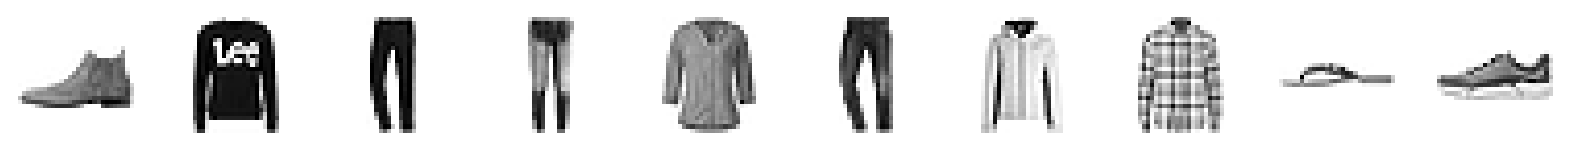

재구성 이미지


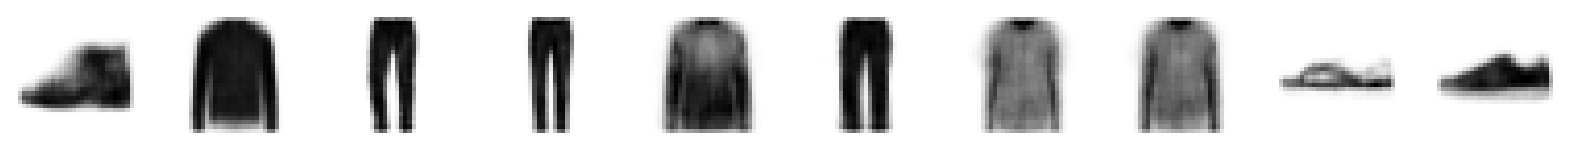

In [24]:
# 오토인코더 예측을 만들고 출력
z_mean, z_log_var, recon = vae.predict(example_images)
print("실제 의류 아이템")
display(example_images)
print("재구성 이미지")
display(recon)

# 인코더 사용하여 임베딩하기

In [25]:
#  예제 이미지 인코딩
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


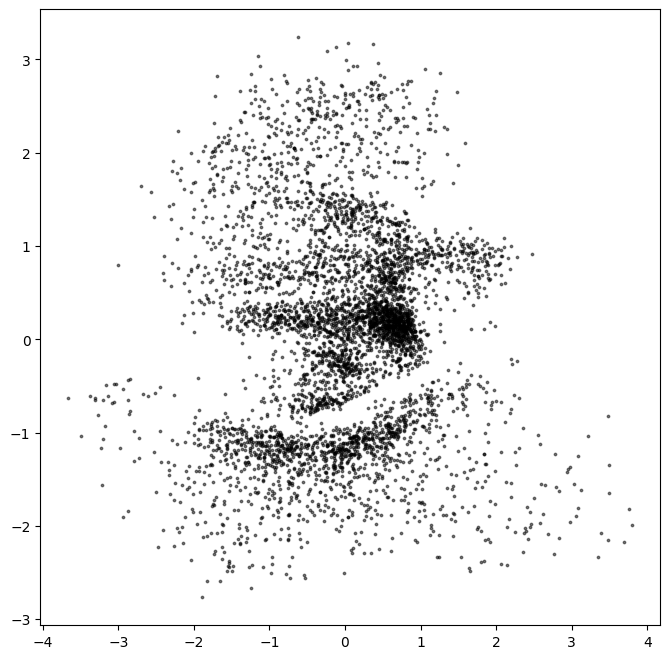

In [26]:
# 2D 공간에서 인코딩된 포인트 표시
figsize = 8

plt.figure(figsize = (figsize, figsize))
plt.scatter(z[:,0], z[:,1], c = 'black', alpha = 0.5, s = 3)
plt.show()

# 디코더를 사용하여 생성하기

In [27]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링
grid_width, grid_height = (6,3)
z_sample = np.random.normal(size = (grid_width * grid_height,2)) # (18,2) 행렬 생성

In [28]:
# 샘플링된 포인트 디코딩
recons = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


In [34]:
# 원본 임베딩과 샘플링된 임베딩을 p값으로 변환하기
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

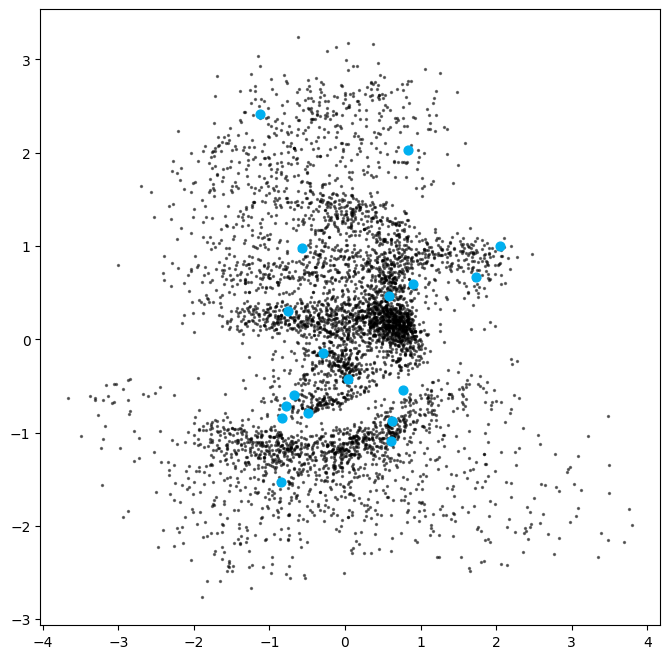

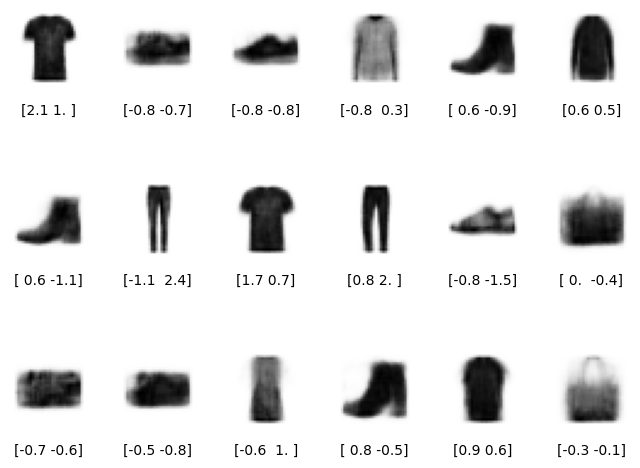

In [38]:
plt.figure(figsize = (figsize, figsize))

# 원본 임베딩
plt.scatter(z[:,0], z[:,1], c = 'black', alpha = 0.5, s = 2)

# 잠재 공간에 새로 생성된 포인트
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드
fig = plt.figure(figsize = (figsize, grid_height * 2))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i in range(grid_width * grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis("off")
  ax.text(
      0.5,
      -0.35,
      str(np.round(z_sample[i, :], 1)),
      fontsize=10,
      ha="center",
      transform=ax.transAxes,
  )
  ax.imshow(recons[i, :, :], cmap="Greys")


#  잠재 공간 탐색

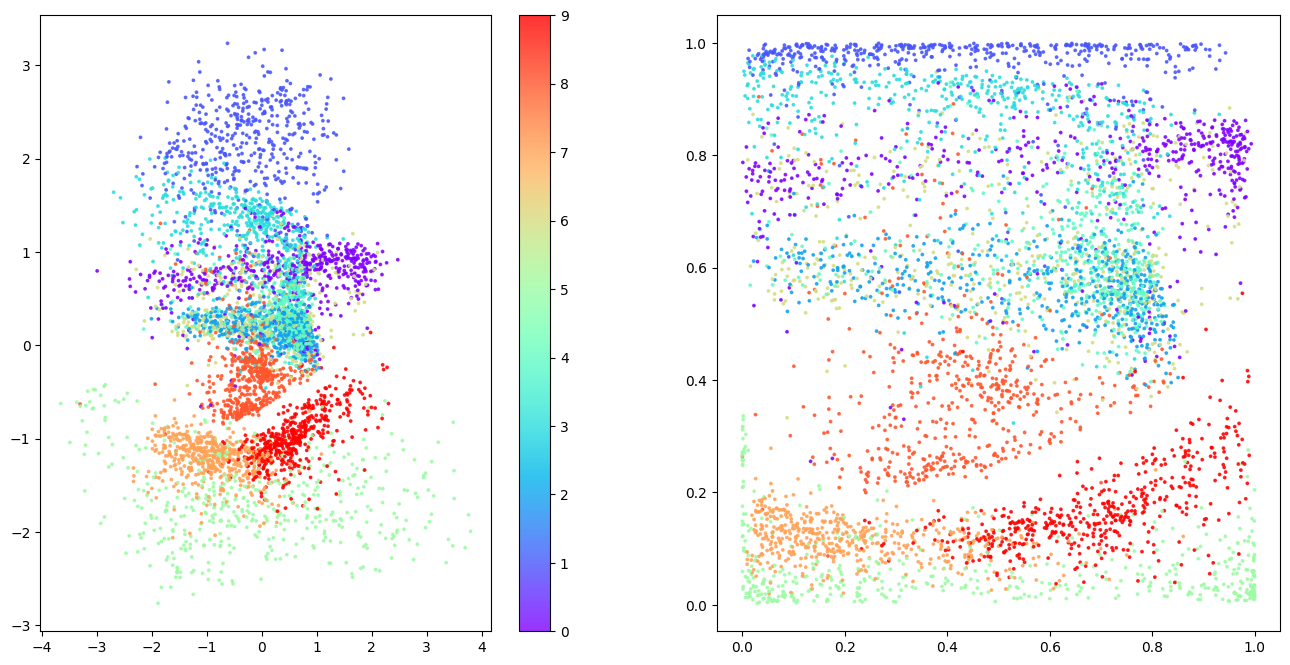

In [39]:
# 레이블(의류 종류)에 따라 임베딩에 색상을 지정
figsize = 8
fig = plt.figure(figsize = (figsize * 2, figsize))
ax = fig.add_subplot(1,2,1)
plot_1 = ax.scatter(
  z[:,0], z[:,1], cmap = "rainbow", c=example_labels, alpha = 0.8, s = 3
)

plt.colorbar(plot_1)

ax = fig.add_subplot(1,2,2)
plot_2 = ax.scatter(
    p[:,0], p[:,1], cmap = 'rainbow', c=example_labels, alpha = 0.8, s = 3
)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


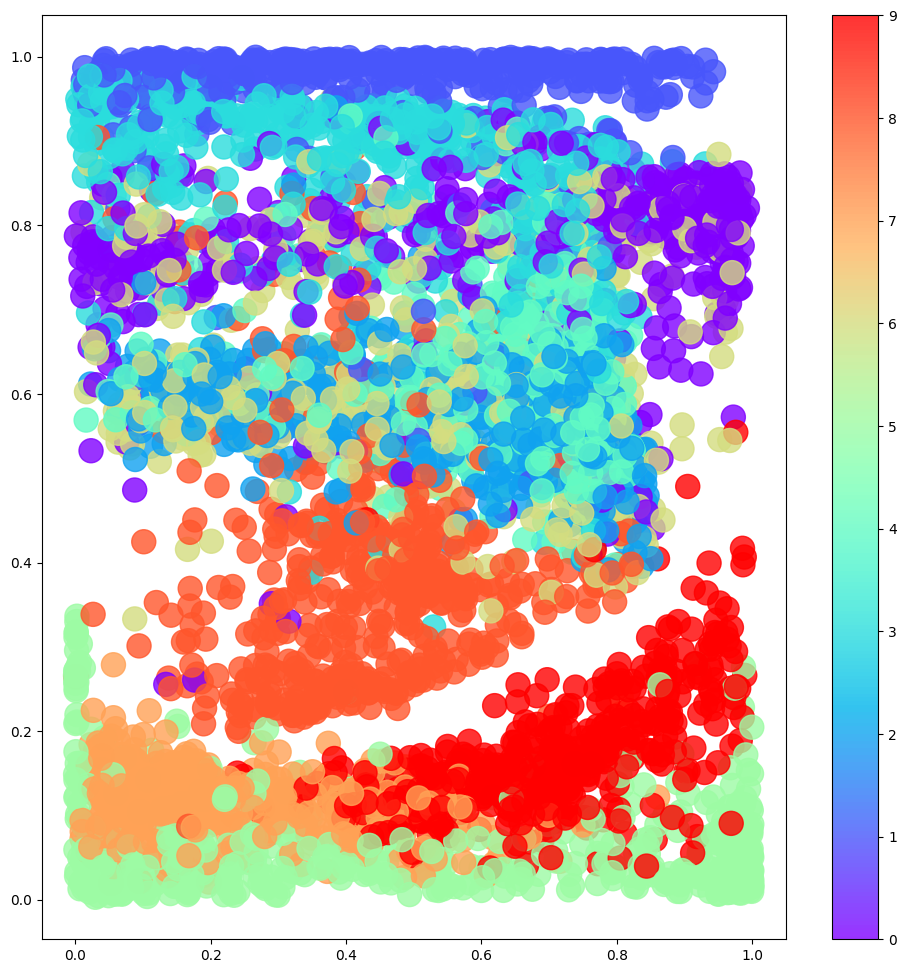

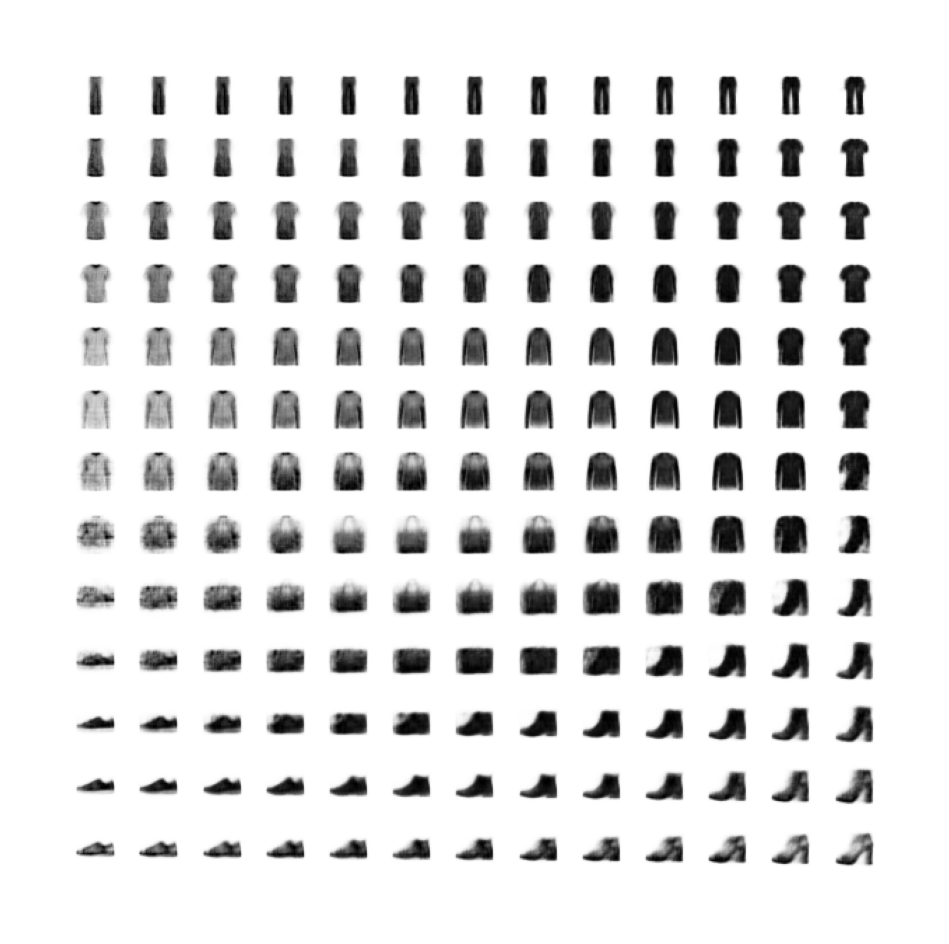

In [40]:
# 레이블(의류 종류)에 따라 임베딩에 색상을 지정합니다.
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")
